In [1]:
# import thư viện

import matplotlib.pyplot as plt
import cv2

In [2]:
# cắt vùng ảnh từ ảnh gốc dựa trên tọa độ cho trước

def extract_image(image, points):
    (x1, y1), (x2, y2) = points

    return image[y1:y2, x1:x2]

In [3]:
# tính IoU

def iou(u, v, shape):
    height, width = shape

    # xác định tọa độ của vùng giao nhau
    x_left = max(u[0], v[0])
    y_top = max(u[1], v[1])
    x_right = min(u[0] + width, v[0] + width)
    y_bottom = min(u[1] + height, v[1] + height)

    # kiểm tra xem có giao nhau không
    if x_right <= x_left or y_bottom <= y_top:
        return 0  # không có giao nhau

    # tính diện tích giao nhau
    intersection = (x_right - x_left) * (y_bottom - y_top)

    # tính diện tích hợp nhất
    union = (width * height) * 2 - intersection

    return intersection / union


In [4]:
class TemplateMatching:
    def __init__(self, points, image_path, scale_factor=1.0):
        """
        Khởi tạo đối tượng TemplateMatching.
        points: Tọa độ góc trên bên trái và góc dưới bên phải của template trong ảnh.
        scale_factor: Hệ số thay đổi kích thước của template (nếu cần).
        """
        self.points = points
        self.image_path = image_path
        self.scale_factor = scale_factor

        self.original_image = cv2.imread(image_path)
        self.template_image = extract_image(self.original_image, points)

        # chuyển ảnh gốc và template sang ảnh xám (chỉ lấy kênh blue)
        self.gray_image = self.original_image[:, :, 2]
        cv2.imwrite('template.png', self.template_image)
        self.template = cv2.imread('template.png')[:, :, 2]
        self.match_locations = []

        # thay đổi kích thước của template theo hệ số scale_factor
        self.template = cv2.resize(self.template, None, fx=scale_factor, fy=scale_factor)

    def visualize(self):
        """
        Hiển thị ảnh gốc.
        """
        plt.title("Original Image")
        plt.imshow(cv2.cvtColor(self.original_image, cv2.COLOR_BGR2RGB))  # chuyển đổi ảnh từ BGR sang RGB để hiển thị đúng màu

    def template_matching_algo(self, threshold=0.08, method=cv2.TM_SQDIFF_NORMED):
        """
        Thực hiện thuật toán Template Matching để tìm kiếm template trong ảnh
        TM_SQDIFF_NORMED (Template Matching with Normalized Squared Difference): đo lường độ tương tự giữa mẫu
        và khu vực trong ảnh theo cách đo sự khác biệt bình phương và chuẩn hóa nó
        """
        search_image = self.gray_image.copy()
        template = self.template.copy()

        # thực hiện template matching
        result = cv2.matchTemplate(search_image, template, method)

        # duyệt qua tất cả các vị trí trong kết quả và lưu các vị trí thỏa mãn ngưỡng
        for i in range(result.shape[0]):
            for j in range(result.shape[1]):
                if result[i, j] < threshold:  # nếu giá trị nhỏ hơn ngưỡng, lưu vị trí
                    self.match_locations.append((j, i))

        # vẽ các kết quả tìm thấy trên ảnh
        count = 1
        for loc in self.match_locations:
            bottom_right = (loc[0] + template.shape[1], loc[1] + template.shape[0])
            cv2.rectangle(self.original_image, loc, bottom_right, (0, 0, 0), 2)
            cv2.putText(self.original_image, str(count), (loc[0], loc[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
            count += 1

    def filter(self):
        """
        Lọc các kết quả trùng lặp bằng cách sử dụng IoU (Intersection over Union).
        """
        final_locations = []  # danh sách kết quả sau khi lọc
        template = self.template  # template cần so sánh

        for u in self.match_locations:
            if len(final_locations) == 0:
                final_locations.append(u)  # thêm vị trí đầu tiên vào danh sách kết quả
            else:
                check = True
                for v in final_locations:
                    overlap = iou(u, v, template.shape)
                    if overlap > 0.5:  # bỏ qua vị trí này vì trùng nhau quá nhiều
                        check = False
                        break
                if check:
                    final_locations.append(u)

        print(f"{len(final_locations)} results found.")

        # vẽ các kết quả
        count = 1
        img_copy = cv2.imread(self.image_path)  # đọc lại ảnh gốc để vẽ kết quả
        for loc in final_locations:  # duyệt qua các kết quả sau khi lọc
            bottom_right = (loc[0] + template.shape[1], loc[1] + template.shape[0])
            cv2.rectangle(img_copy, loc, bottom_right, (0, 0, 0), 1)
            cv2.putText(img_copy, str(count), (loc[0], loc[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            count += 1

        # hiển thị ảnh với các kết quả đã lọc
        plt.figure(figsize=(8, 8), dpi=80)
        plt.imshow(img_copy[:, :, ::-1])  # đảo chiều màu BGR sang RGB
        plt.show()

14 results found.


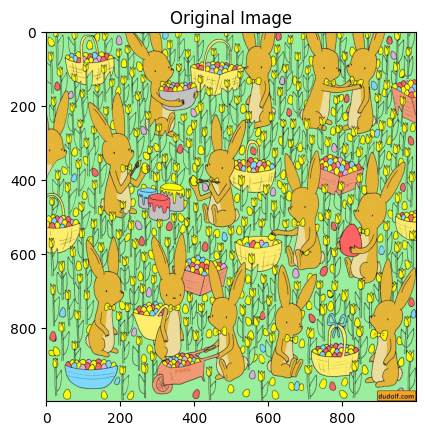

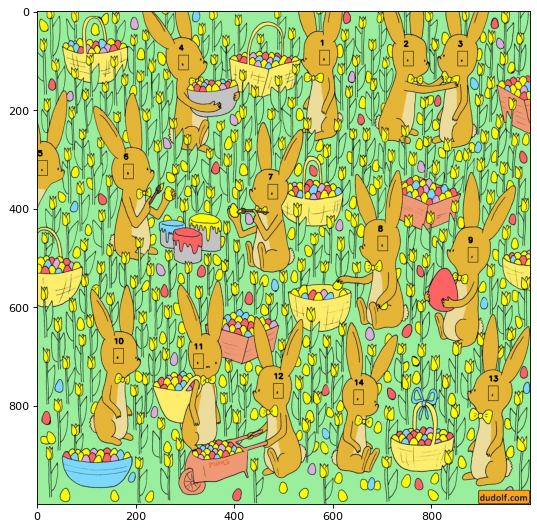

In [5]:
path = 'rabbit.jpeg'
points = [(155, 685), (175, 715)]

template_matching = TemplateMatching(points, path)

template_matching.visualize()

template_matching.template_matching_algo(threshold=0.01)
template_matching.filter()